# Mask R-CNN 검증 지표

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

ROOT_DIR = './'

sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

In [2]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [4]:
class CocoLikeDataset(utils.Dataset):
    def load_data(self, annotation_json, images_dir):
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

Train, Valid 데이터 확인

In [5]:
dataset_val = CocoLikeDataset()
dataset_val.load_data('json/path', 'image/path')
dataset_val.prepare()

print('Validation', len(dataset_val.image_ids))

Validation 14853


평가 지표 출력 (Pixel Accuracy, IoU, mAP)

In [6]:
class InferenceConfig(TrainConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.85

inference_config = InferenceConfig()

# Recreate the model in inference mode
test_model = modellib.MaskRCNN(
    mode="inference", 
    config=inference_config,
    model_dir=MODEL_DIR)

model_path = 'model/path'
# model_path = test_model.find_last()
print(model_path)

test_model.load_weights(model_path, by_name=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead
C:\Users\JINMIN\Documents\test\python\Mask_RCNN\logs\custom20240827T1602\mask_rcnn_custom_0010.h5
Re-starting from epoch 10


In [7]:
from sklearn.metrics import jaccard_score, precision_recall_curve, auc, accuracy_score
import numpy as np
import skimage.io
import skimage.transform

def evaluate_model(model, dataset):
    pixel_accuracies = []
    ious_per_class = [[] for _ in range(2)]  # 두 클래스: "parking space"와 "driveable space"
    aps_per_class = [[] for _ in range(2)]
    aps_50_per_class = [[] for _ in range(2)]  # IoU 0.5 이상에서의 AP

    # 데이터셋의 각 이미지를 순회하면서 예측 수행
    for i in range(len(dataset.image_ids)):
        img_id = dataset.image_ids[i]
        img_path = dataset.image_info[img_id]['path']

        # 이미지 및 Ground truth 마스크 로드
        img = skimage.io.imread(img_path)
        true_mask, true_class_ids = dataset.load_mask(img_id)
        true_mask_binary = true_mask[:, :, 0] > 0  # 첫 번째 마스크 사용하여 픽셀 정확도 계산

        # 모델 예측 수행
        results = model.detect([img], verbose=0)[0]

        # 예측된 마스크와 클래스 ID 추출
        if 'masks' in results and results['masks'].size > 0:
            pred_masks = results['masks']
            pred_class_ids = results['class_ids']
            pred_mask = pred_masks[:, :, 0]  # 첫 번째 마스크 사용하여 픽셀 정확도 계산
        else:
            pred_masks = np.zeros_like(true_mask)
            pred_class_ids = []
            pred_mask = np.zeros(true_mask.shape[:2], dtype=bool)

        # 예측된 마스크 크기 조정 및 이진화 (픽셀 정확도)
        pred_mask_resized = skimage.transform.resize(pred_mask, true_mask_binary.shape, preserve_range=True)
        pred_mask_binary = pred_mask_resized > 0.5

        # 픽셀 정확도 계산
        pixel_accuracy = accuracy_score(true_mask_binary.flatten(), pred_mask_binary.flatten())
        pixel_accuracies.append(pixel_accuracy)

        # 각 클래스별로 IoU 및 AP 계산 ("parking space" = 1, "driveable space" = 2)
        for class_id, class_name in enumerate(["parking space", "driveable space"], start=1):
            true_class_mask = np.sum(true_mask[:, :, np.where(true_class_ids == class_id)[0]], axis=-1) > 0
            pred_class_mask = np.sum(pred_masks[:, :, np.where(pred_class_ids == class_id)[0]], axis=-1) > 0

            # 마스크를 이진화하고 평탄화
            true_mask_flat = true_class_mask.flatten()
            pred_mask_flat = pred_class_mask.flatten()

            # IoU 계산
            if np.sum(true_mask_flat) > 0 or np.sum(pred_mask_flat) > 0:
                iou = jaccard_score(true_mask_flat, pred_mask_flat)
                ious_per_class[class_id - 1].append(iou)

                # IoU 0.5 이상일 때만 AP 계산
                if iou >= 0.5:
                    precision, recall, _ = precision_recall_curve(true_mask_flat, pred_mask_flat)
                    if len(recall) > 0 and len(precision) > 0:
                        ap = auc(recall, precision)
                        aps_50_per_class[class_id - 1].append(ap)

            # 모든 IoU에서 AP 계산
            precision, recall, _ = precision_recall_curve(true_mask_flat, pred_mask_flat)
            if len(recall) > 0 and len(precision) > 0:
                ap = auc(recall, precision)
                aps_per_class[class_id - 1].append(ap)

    # 클래스별 IoU 및 AP 평균 계산
    mean_ious = [np.mean(iou_list) if len(iou_list) > 0 else 0 for iou_list in ious_per_class]
    mean_aps = [np.mean(ap_list) if len(ap_list) > 0 else 0 for ap_list in aps_per_class]
    mean_aps_50 = [np.mean(ap_list) if len(ap_list) > 0 else 0 for ap_list in aps_50_per_class]

    # mIoU 및 mAP 계산
    miou = np.mean(mean_ious)
    map_value = np.mean(mean_aps)
    map_50_value = np.mean(mean_aps_50)

    # 결과 출력
    print(f"Pixel Accuracy: {np.mean(pixel_accuracies)}")
    print(f"mIoU: {miou}")
    print(f"mAP: {map_value}")
    print(f"mAP@IoU 0.5: {map_50_value}")

    return {
        'pixel_accuracy': np.mean(pixel_accuracies),
        'class_iou': mean_ious,
        'class_ap': mean_aps,
        'class_ap_50': mean_aps_50,
        'miou': miou,
        'map': map_value,
        'map_50': map_50_value,
        'iou_per_class': ious_per_class,
        'aps_per_class': aps_per_class,
        'aps50_per_class': aps_50_per_class
    }

In [8]:
# 평가 수행
results = evaluate_model(test_model, dataset_val)

c:\Users\JINMIN\anaconda3\envs\parking\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
c:\Users\JINMIN\anaconda3\envs\parking\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\JINMIN\anaconda3\envs\parking\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\JINMIN\anaconda3\envs\parking\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\JINMIN\anaconda3\envs\parking\lib\site-packages\sklearn

Pixel Accuracy: 0.9230446988057551
mIoU: 0.4743580351385484
mAP: 0.6742238175553393
mAP@IoU 0.5: 0.8469636482217371


PR curve

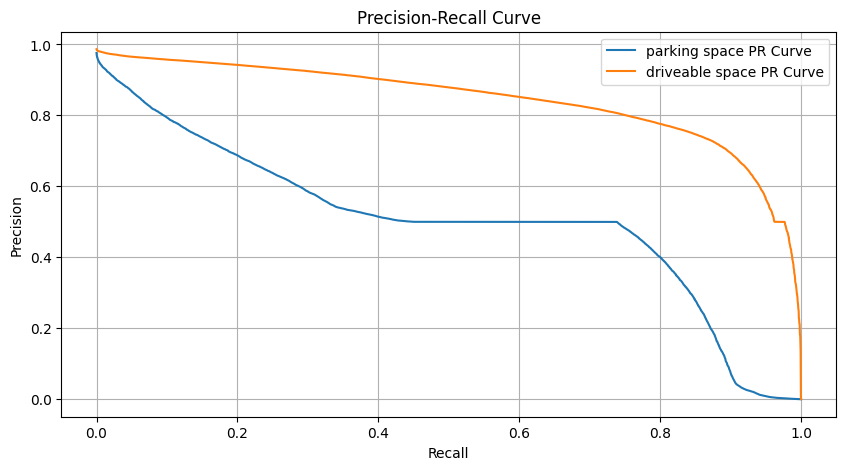

In [13]:
import matplotlib.pyplot as plt


def plot_pr_curve(aps_per_class):
    """
    Precision-Recall Curve를 그리는 함수.

    Args:
        aps_per_class (list of list): 각 클래스별 AP 리스트.
    """
    plt.figure(figsize=(10, 5))
    
    # 각 클래스별로 Precision-Recall Curve를 그림
    for class_id, class_name in enumerate(["parking space", "driveable space"], start=1):
        # 클래스 AP 리스트가 비어있지 않을 때만 PR Curve를 그림
        if len(aps_per_class[class_id - 1]) > 0:
            # AP 데이터로부터 임시 precision과 recall을 설정 (예시)
            ap_values = aps_per_class[class_id - 1]
            recall = np.linspace(0, 1, len(ap_values))
            precision = np.interp(recall, np.linspace(0, 1, len(ap_values)), sorted(ap_values, reverse=True))

            # PR Curve 그리기
            plt.plot(recall, precision, label=f'{class_name} PR Curve')
    
    # 그래프 라벨링 및 표시
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# 예시로 평가 결과를 전달하여 PR Curve를 그림
plot_pr_curve(results['aps_per_class'])
